In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.FD import *

19:26:24 (  +25.3s) [INFO   ] -- import logging
19:26:24 (  +102ms) [INFO   ] -- import numpy as np
19:26:24 (   +11ms) [INFO   ] -- import uncertainties
19:26:24 (  +242ms) [INFO   ] -- import pandas as pd
19:26:24 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
19:26:24 (    +1ms) [INFO   ] -- import binaries.tools as tools
19:26:25 (  +290ms) [INFO   ] -- import matplotlib.pyplot as plt
19:26:25 (  +353ms) [INFO   ] -- import seaborn as so
19:26:25 (    +6ms) [DEBUG  ] -- font size set to 9.5
19:26:25 (    +0ms) [DEBUG  ] -- label size set to 13.0
19:26:25 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
19:26:25 (    +0ms) [DEBUG  ] -- markersize set to 2.0
19:26:25 (    +1ms) [DEBUG  ] -- usetex set to False
19:26:25 (    +1ms) [INFO   ] -- import plotting.tools as plot


In [2]:
import pickle

with open('/cr/users/filip/Projects/xy-reproducibility/reproducibility_dataset.pkl', 'rb') as pkl:
    data = pickle.load(pkl)

pairs = {}

for key, values in data.items():
    if 'he' in key: continue
    if len(values) < 2: continue

    if key == 'co5':
        pairs[key] = [values[0], values[2]]
    else:
        pairs[key] = values

In [3]:
print(pairs.keys())

dict_keys(['co5', 'co3', 'co4', 'la3', 'la4', 'co2'])


In [4]:
runs = data['co4']

<Axes: >

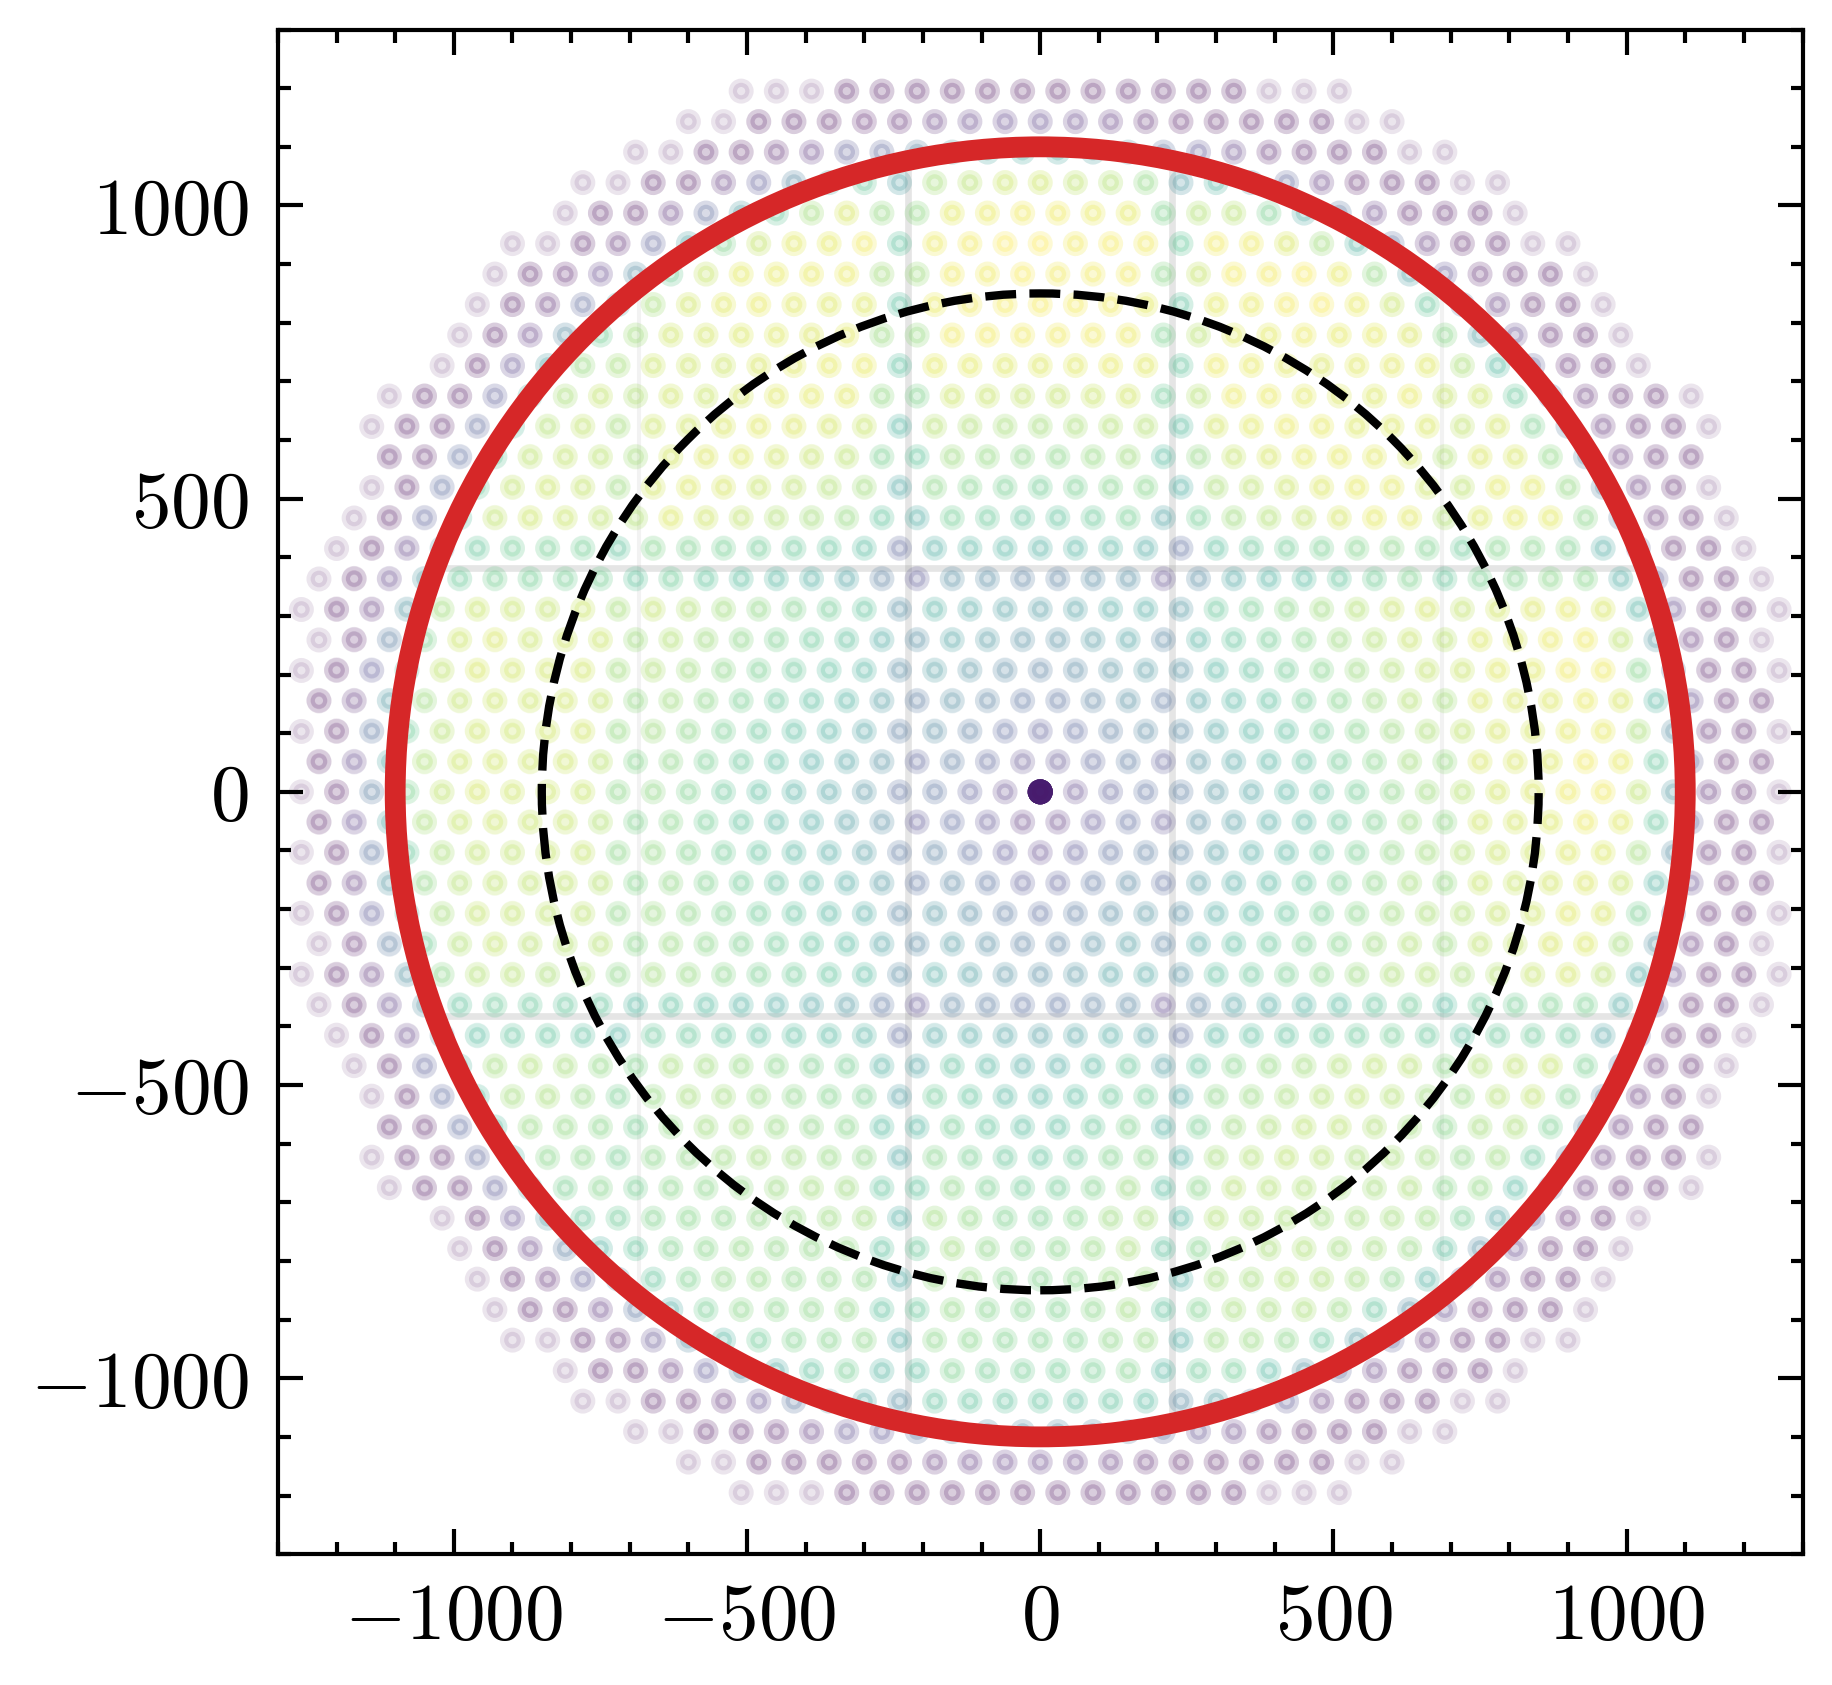

In [6]:
result_dir = '/cr/data01/filip/xy-calibration/results'
fig, ax = plt.subplots()

positions_normalized = []

for run in runs:
    xy, CalAs = run['XY'], run['CalA_open_shutter']
    try:
        CalA_signal = np.zeros(440)
        for CalA in CalAs:
            CalA_signal += np.loadtxt(f"{result_dir}/out_{CalA}.txt", usecols=[2])

    except (IndexError, AssertionError):
        print("Malformed CalA data received, please make sure you pass \
            in two CalAs (pre/post-XY), which have 440 pixels of data")

    pixels = np.loadtxt(f"{result_dir}/out_{xy}.txt", usecols=[2])
    positions = pd.read_csv(f"{result_dir}/outPositionsComb_{xy}.txt", usecols=['x', 'y', 'FDeventSum'])
    
    positions_normalized.append(positions)


    c0 = ax.scatter(positions.x, positions.y, c=positions['FDeventSum'],
                     marker='o', s = 4, alpha = 0.1)

AperturePlot(ax)

In [8]:
positions_combined = positions_normalized[0].merge(positions_normalized[1] ,on =['x','y']).drop_duplicates().dropna()
positions_ratio = positions_combined.FDeventSum_x / positions_combined.FDeventSum_y

<Axes: >

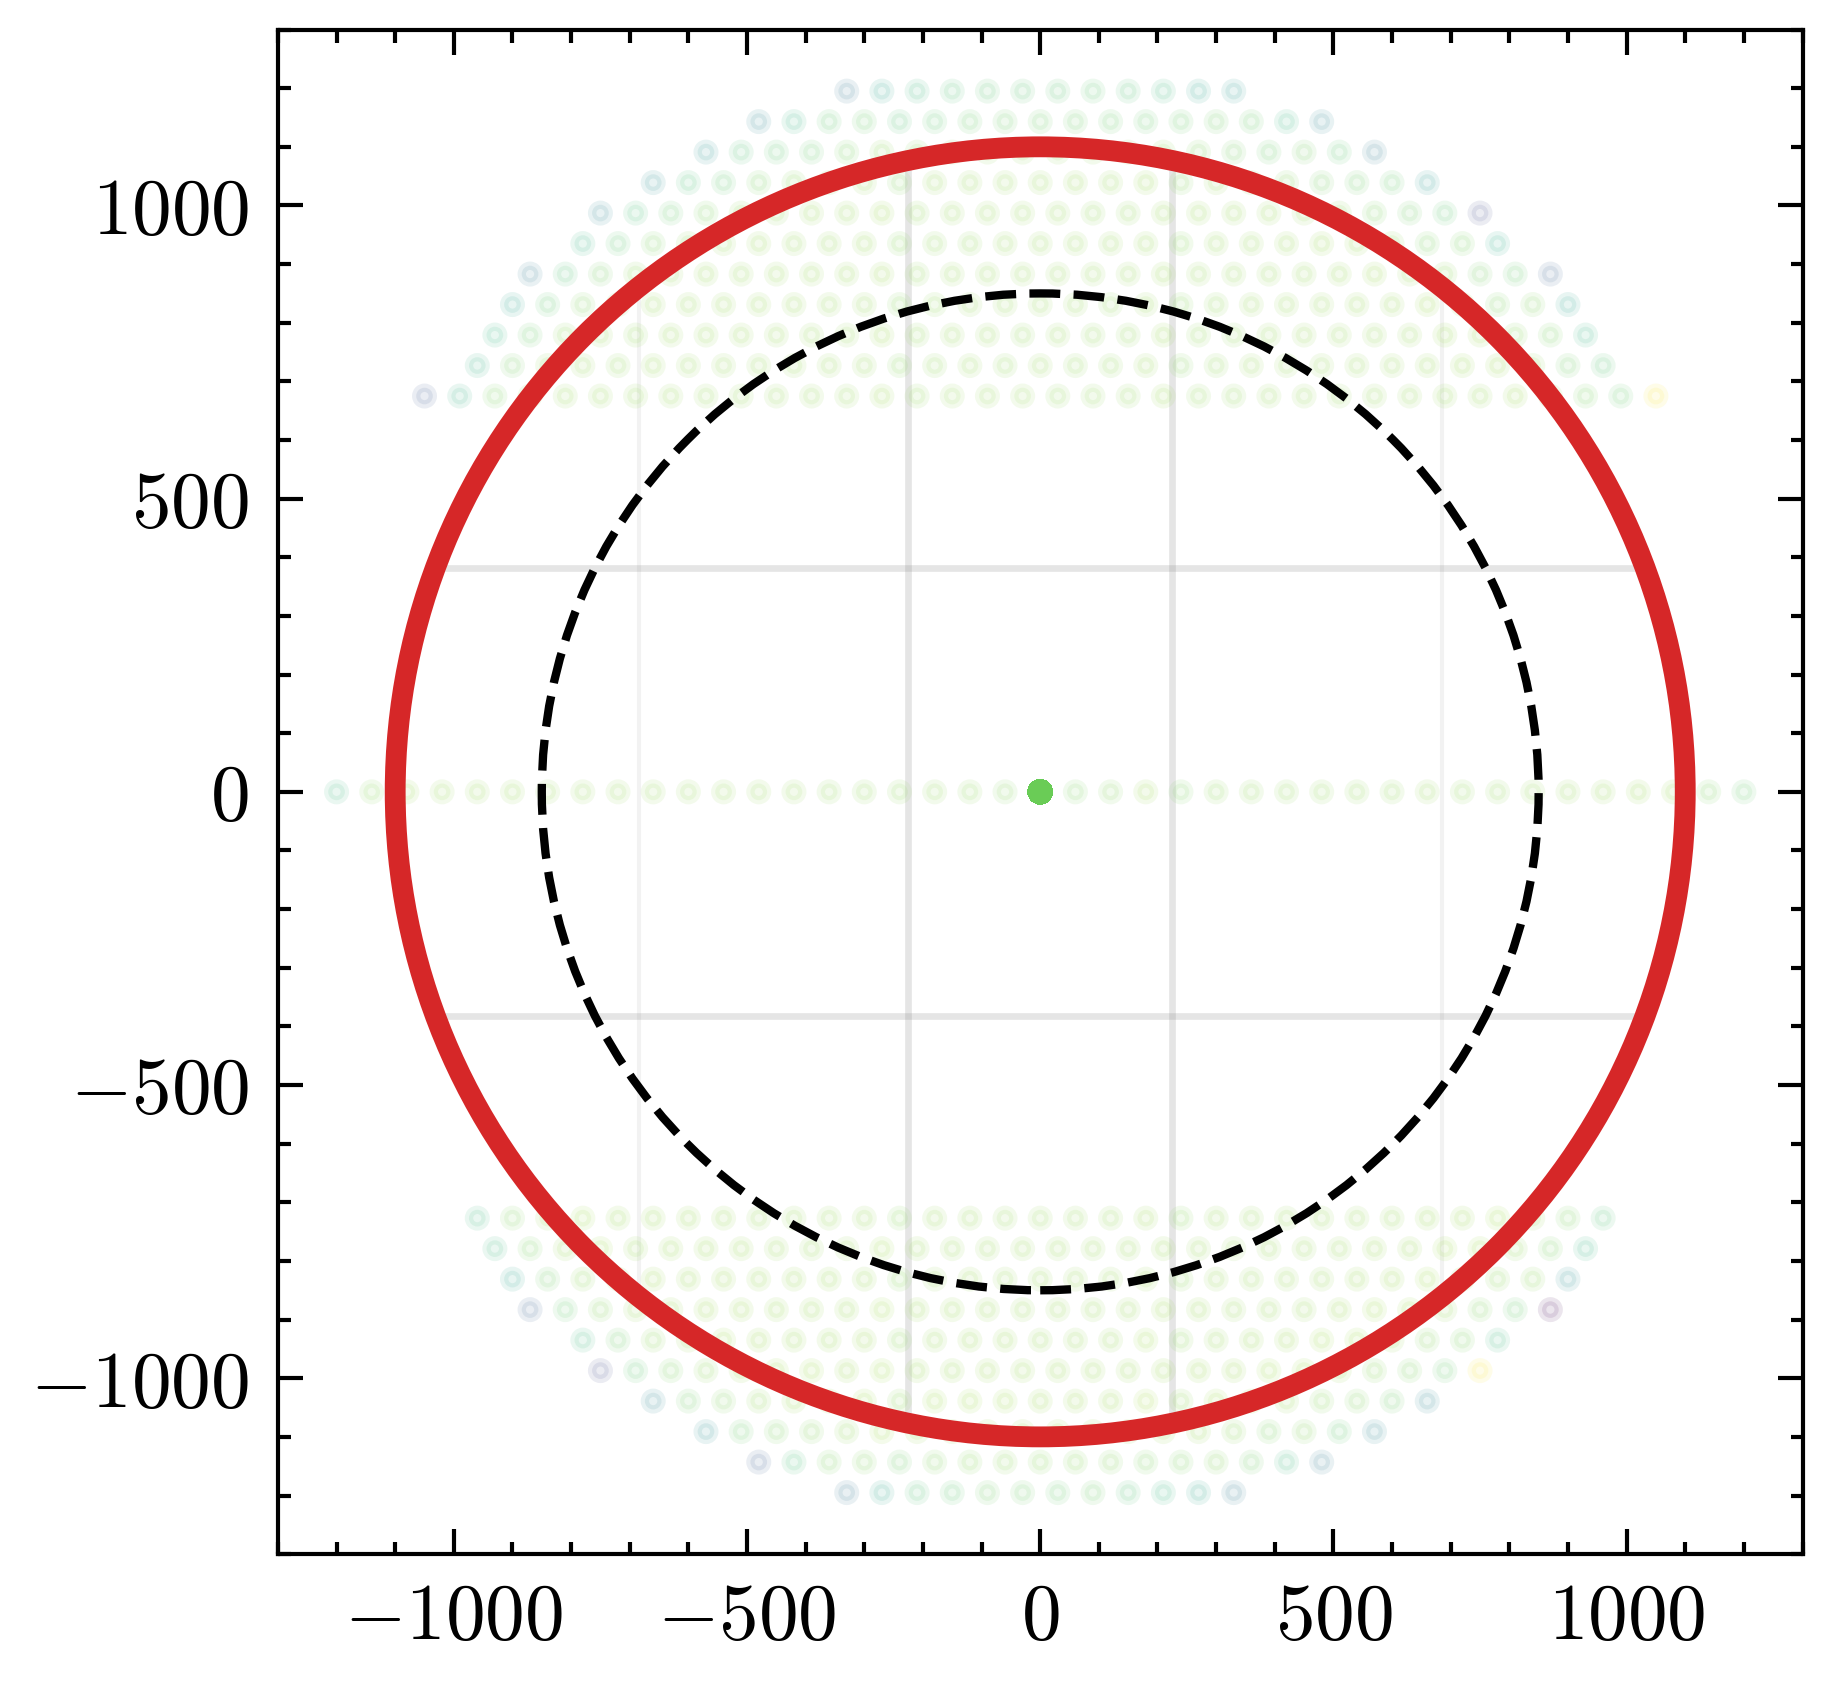

In [9]:
fig, ax = plt.subplots()

c0 = ax.scatter(positions_combined.x, positions_combined.y, marker='o', s = 4, alpha = 0.1, c=positions_ratio)
AperturePlot(ax)

In [8]:
dataset = pd.concat([positions_normalized[0], positions_normalized[1]])

In [34]:
dataset.groupby(dataset.index)

In [22]:
for i, (key, thing) in enumerate(dataset.groupby('y')):
    if i < 15: continue

    print(thing.x)

    break

370   -1110.0
371   -1050.0
372    -990.0
373    -930.0
374    -870.0
375    -810.0
376    -750.0
377    -690.0
378    -630.0
379    -570.0
380    -510.0
381    -450.0
382    -390.0
383    -330.0
384    -270.0
385    -210.0
386    -150.0
387     -90.0
388     -30.0
389      30.0
390      90.0
391     150.0
392     210.0
393     270.0
394     330.0
395     390.0
396     450.0
397     510.0
398     570.0
399     630.0
400     690.0
401     750.0
402     810.0
403     870.0
404     930.0
405     990.0
406    1050.0
407    1110.0
Name: x, dtype: float64


In [7]:
first, second = positions_normalized

In [8]:
print(len(first), len(second))

1693 1587


In [116]:

def build_xy_ratio(data1, data2):

    pd.options.mode.chained_assignment = None

    # multiple flashes at position 0
    d1_zeros = data1.loc[data1['x'] + data1['y'] == 0]
    d2_zeros = data2.loc[data2['x'] + data2['y'] == 0]

    data1 = pd.concat([data1, d1_zeros, d1_zeros]).drop_duplicates(keep=False)
    data2 = pd.concat([data2, d2_zeros, d2_zeros]).drop_duplicates(keep=False)

    ratios = pd.DataFrame({'x' : 0, 'y' : 0, 'ratio' : d1_zeros['FDeventSum'].mean() / d2_zeros['FDeventSum'].mean()}, index=[0])

    # all other flashes
    smaller_dataset = data1 if len(data1) < len(data2) else data2
    larger_dataset = data2 if len(data1) < len(data2) else data1
    factor = lambda x: x if len(data1) < len(data2) else 1/x

    for i, (_, row) in enumerate(smaller_dataset.iterrows(), 1):
    
        try:

            y_distances = (larger_dataset['y'] - row.loc['y']).abs()
            closest_y = larger_dataset.iloc[y_distances.argmin()]['y']

            same_row = larger_dataset[larger_dataset['y'] == closest_y]
            same_row['x_distances'] = (same_row['x'] - row.loc['x']).abs()

            closest_xy = same_row.iloc[same_row['x_distances'].argmin()]

            ratio = factor(row['FDeventSum']/closest_xy['FDeventSum'])
            this_ratio = pd.DataFrame({'x' : row['x'], 'y' : row['y'], 'ratio' : ratio}, index=[i])
            ratios = pd.concat([ratios, this_ratio], ignore_index=True)
        except ValueError:
            pass

    return ratios

In [117]:
test = build_xy_ratio(first, second)

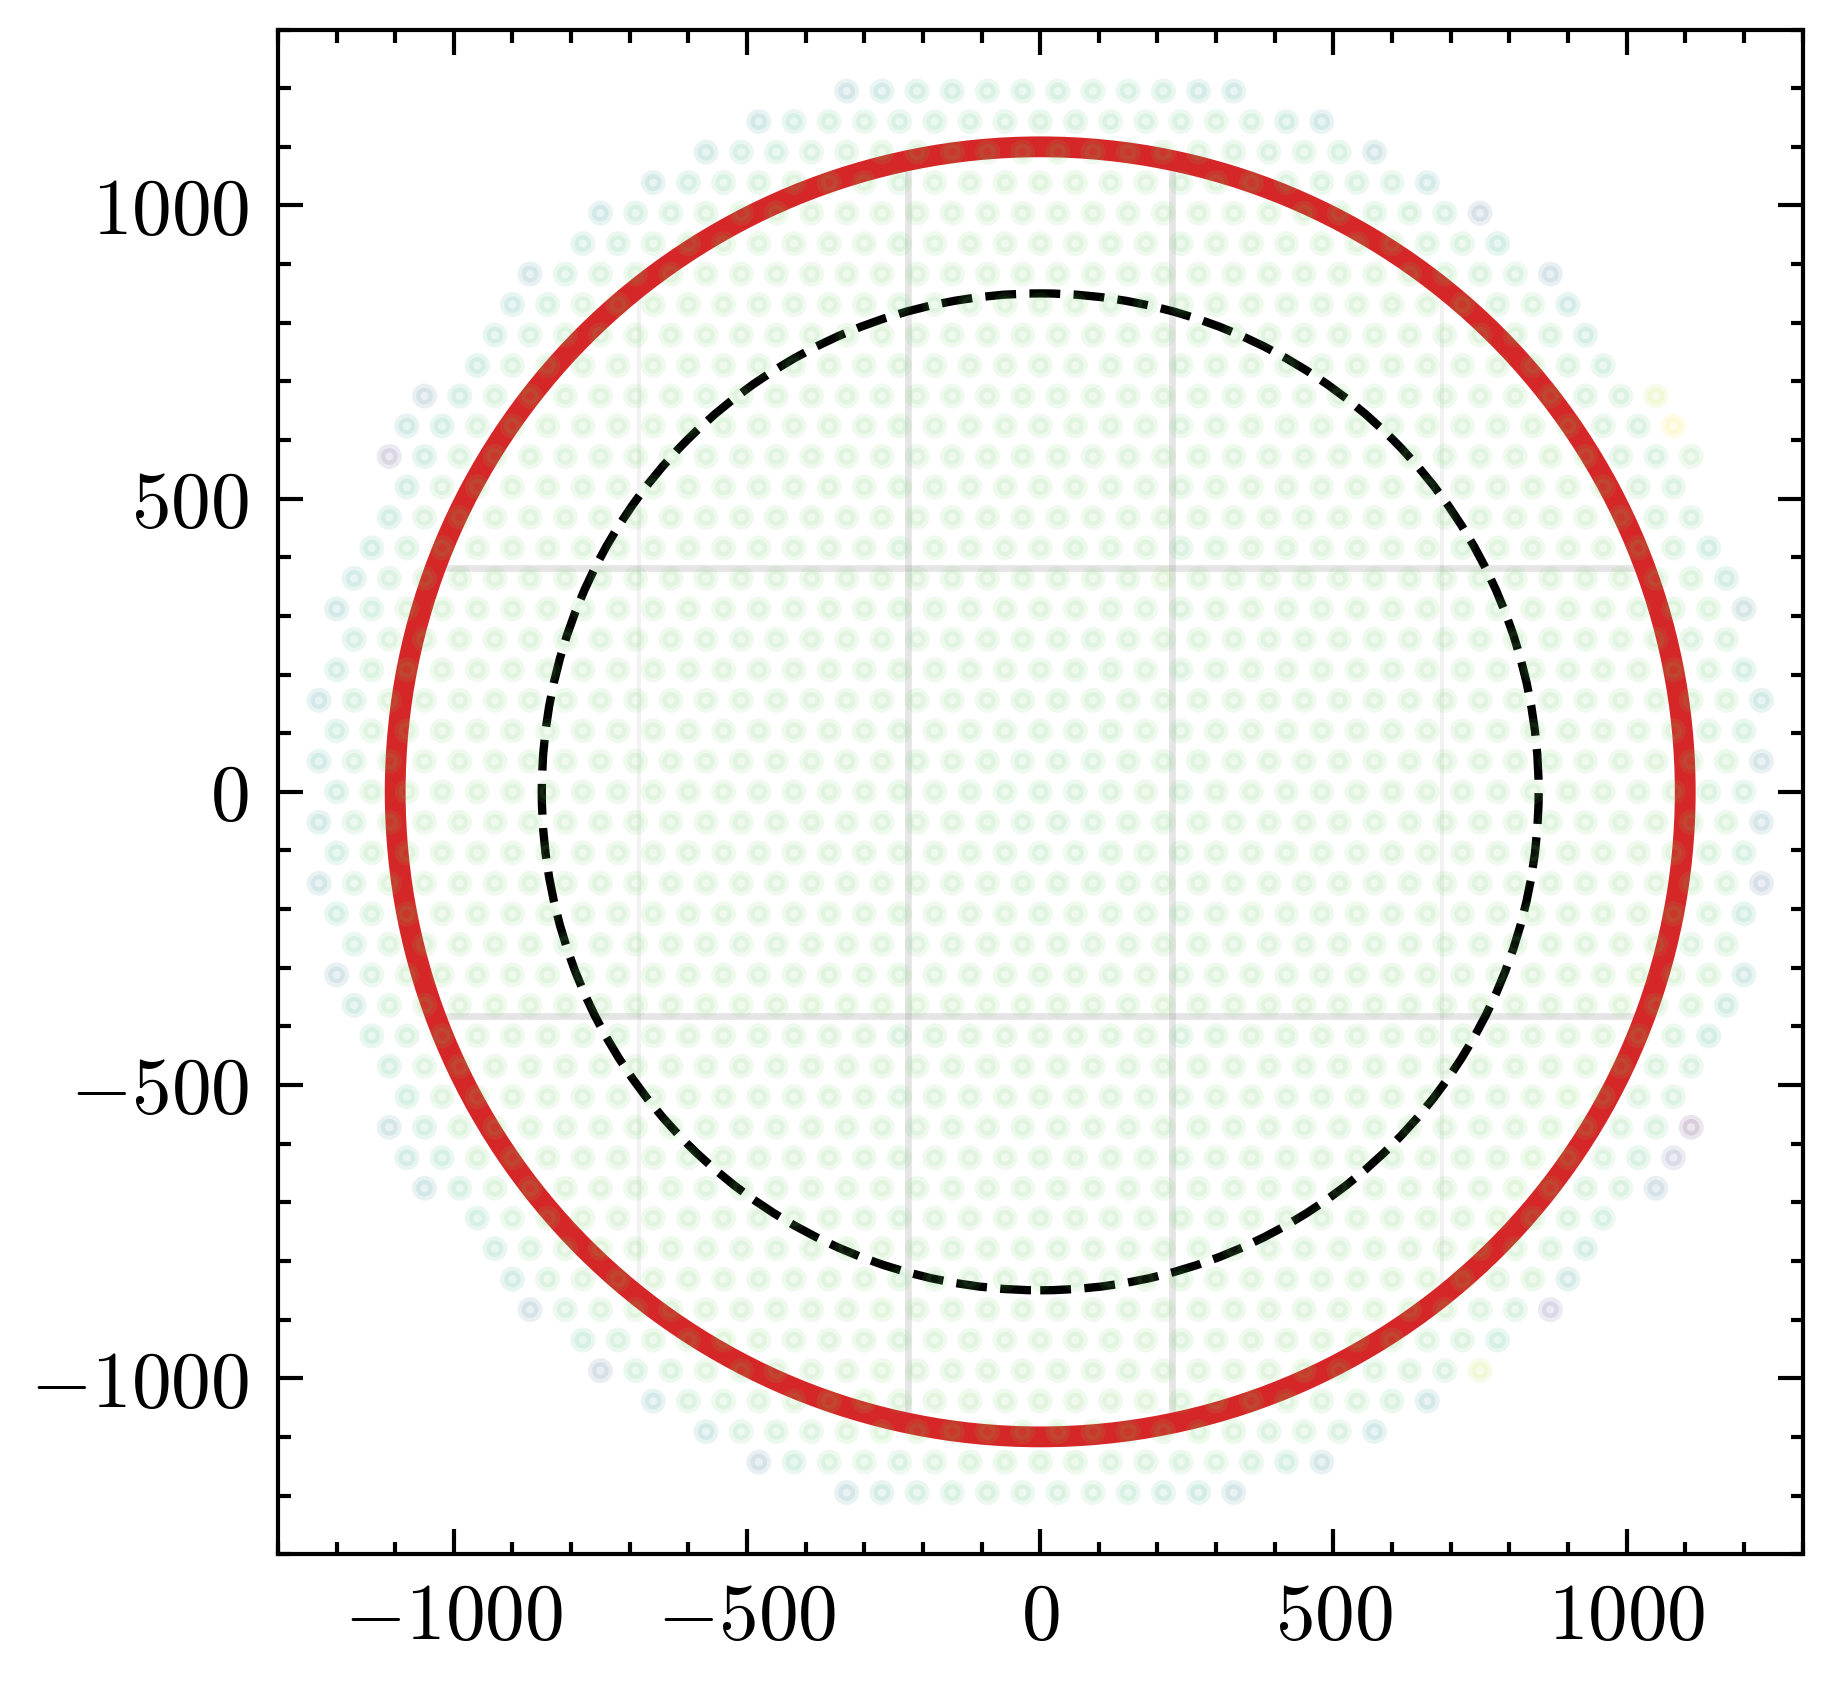

In [118]:
fig, ax = plt.subplots()

AperturePlot(ax)
c0 = ax.scatter(test.x, test.y, c=test['ratio'], marker='o', s = 4, alpha = 0.1)


In [107]:
for thing, _ in first.groupby('y'):
    print(thing)

-1195.0
-1143.0
-1091.0
-1039.0
-987.0
-935.0
-883.0
-831.0
-779.0
-727.0
-675.0
-623.0
-571.0
-519.0
-467.0
-415.0
-363.0
-311.0
-259.0
-207.0
-155.0
-103.0
-51.0
0.0
51.0
103.0
155.0
207.0
259.0
311.0
363.0
415.0
467.0
519.0
571.0
623.0
675.0
727.0
779.0
831.0
883.0
935.0
987.0
1039.0
1091.0
1143.0
1195.0


In [108]:
for thing, _ in second.groupby('y'):
    print(thing)

-1195.0
-1143.0
-1091.0
-1039.0
-987.0
-935.0
-883.0
-831.0
-779.0
-727.0
-676.0
-624.0
-572.0
-520.0
-468.0
-416.0
-364.0
-312.0
-260.0
-208.0
-156.0
-104.0
-52.0
0.0
52.0
104.0
156.0
208.0
260.0
312.0
364.0
416.0
468.0
520.0
572.0
624.0
675.0
727.0
779.0
831.0
883.0
935.0
987.0
1039.0
1091.0
1143.0
1195.0
